# Test 15 {#sec-test_15}
The circuit in @fig-test_15 has no unknown current sources. The Python code generates the following empty matrices: B, C, D, J, Ev.

![test circuit](test_15.png){#fig-test_15}

```
* test_15.asc
I1 1 0 1
R1 1 0 10
R2 2 1 10
R3 3 2 1000
C1 2 0 0.01
C2 3 0 0.002
```

In [1]:
#import os
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

## Load the net list

In [2]:
net_list = '''
I1 1 0 1
R1 1 0 10
R2 2 1 10
R3 3 2 1000
C1 2 0 0.01
C2 3 0 0.002
'''

## Call the symbolic modified nodal analysis function

In [3]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

Display the equations

In [4]:
# reform X and Z into Matrix type for printing
Xp = Matrix(X)
Zp = Matrix(Z)
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*Xp)[i:i+1][0],Zp[i])))

Markdown(temp)

$v_{1} \cdot \left(\frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{2}}{R_{2}} = - I_{1}$<br>$v_{2} \left(C_{1} s + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) - \frac{v_{3}}{R_{3}} - \frac{v_{1}}{R_{2}} = 0$<br>$v_{3} \left(C_{2} s + \frac{1}{R_{3}}\right) - \frac{v_{2}}{R_{3}} = 0$<br>

### Netlist statistics

In [5]:
print(report)

Net list report
number of lines in netlist: 6
number of branches: 6
number of nodes: 3
number of unknown currents: 0
number of RLC (passive components): 5
number of inductors: 0
number of independent voltage sources: 0
number of independent current sources: 1
number of op amps: 0
number of E - VCVS: 0
number of G - VCCS: 0
number of F - CCCS: 0
number of H - CCVS: 0
number of K - Coupled inductors: 0



### Connectivity Matrix

In [6]:
A

⎡1    1        -1                  ⎤
⎢── + ──       ───            0    ⎥
⎢R₂   R₁        R₂                 ⎥
⎢                                  ⎥
⎢  -1            1    1      -1    ⎥
⎢  ───    C₁⋅s + ── + ──     ───   ⎥
⎢   R₂           R₃   R₂      R₃   ⎥
⎢                                  ⎥
⎢              -1                1 ⎥
⎢   0          ───        C₂⋅s + ──⎥
⎣               R₃               R₃⎦

### Unknown voltages and currents

In [7]:
X

### Known voltages and currents

In [8]:
Z

### Network dataframe

In [9]:
network_df

,element,p node,n node,cp node,cn node,Vout,value,Vname,Lname1,Lname2
0,I1,1,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,R1,1,0,NaN,NaN,NaN,10.0,NaN,NaN,NaN
2,R2,2,1,NaN,NaN,NaN,10.0,NaN,NaN,NaN
3,R3,3,2,NaN,NaN,NaN,1000.0,NaN,NaN,NaN
4,C1,2,0,NaN,NaN,NaN,0.01,NaN,NaN,NaN
5,C2,3,0,NaN,NaN,NaN,0.002,NaN,NaN,NaN


### Unknown current dataframe

In [10]:
i_unk_df

,element,p node,n node


### Build the network equation matrix

In [11]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)
NE_sym

⎡         ⎛1    1 ⎞   v₂      ⎤        
⎢      v₁⋅⎜── + ──⎟ - ──      ⎥        
⎢         ⎝R₂   R₁⎠   R₂      ⎥        
⎢                             ⎥   ⎡-I₁⎤
⎢   ⎛       1    1 ⎞   v₃   v₁⎥   ⎢   ⎥
⎢v₂⋅⎜C₁⋅s + ── + ──⎟ - ── - ──⎥ = ⎢ 0 ⎥
⎢   ⎝       R₃   R₂⎠   R₃   R₂⎥   ⎢   ⎥
⎢                             ⎥   ⎣ 0 ⎦
⎢        ⎛       1 ⎞   v₂     ⎥        
⎢     v₃⋅⎜C₂⋅s + ──⎟ - ──     ⎥        
⎣        ⎝       R₃⎠   R₃     ⎦        

In [12]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

## Symbolic solution

In [13]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [14]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = \frac{- C_{1} C_{2} I_{1} R_{1} R_{2} R_{3} s^{2} - C_{1} I_{1} R_{1} R_{2} s - C_{2} I_{1} R_{1} R_{2} s - C_{2} I_{1} R_{1} R_{3} s - I_{1} R_{1}}{C_{1} C_{2} R_{1} R_{3} s^{2} + C_{1} C_{2} R_{2} R_{3} s^{2} + C_{1} R_{1} s + C_{1} R_{2} s + C_{2} R_{1} s + C_{2} R_{2} s + C_{2} R_{3} s + 1}$<br>$v_{2} = \frac{- C_{2} I_{1} R_{1} R_{3} s - I_{1} R_{1}}{C_{1} C_{2} R_{1} R_{3} s^{2} + C_{1} C_{2} R_{2} R_{3} s^{2} + C_{1} R_{1} s + C_{1} R_{2} s + C_{2} R_{1} s + C_{2} R_{2} s + C_{2} R_{3} s + 1}$<br>$v_{3} = - \frac{I_{1} R_{1}}{C_{1} C_{2} R_{1} R_{3} s^{2} + C_{1} C_{2} R_{2} R_{3} s^{2} + C_{1} R_{1} s + C_{1} R_{2} s + C_{2} R_{1} s + C_{2} R_{2} s + C_{2} R_{3} s + 1}$<br>

## Construct a dictionary of element values

In [15]:
element_values = SymMNA.get_part_values(network_df)
element_values

In [16]:
element_values

## DC operating point
Both ?



V4 and I2 are active.

In [17]:
NE = NE_sym.subs(element_values)
NE_dc = NE.subs({s:0})
NE_dc

⎡       0.2⋅v₁ - 0.1⋅v₂       ⎤   ⎡-1.0⎤
⎢                             ⎥   ⎢    ⎥
⎢-0.1⋅v₁ + 0.101⋅v₂ - 0.001⋅v₃⎥ = ⎢ 0  ⎥
⎢                             ⎥   ⎢    ⎥
⎣    -0.001⋅v₂ + 0.001⋅v₃     ⎦   ⎣ 0  ⎦

In [18]:
U_dc = solve(NE_dc,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [19]:
table_header = ['unknown', 'mag']
table_row = []

for name, value in U_dc.items():
    table_row.append([str(name),float(value)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal'),tablefmt="simple",floatfmt=('5s','.6f')))

unknown           mag
---------  ----------
v1         -10.000000
v2         -10.000000
v3         -10.000000


The node voltages and current through the sources are solved for. The Sympy generated solution matches the LTSpice results:
```
       --- Operating Point ---

V(1):	 -10	 voltage
V(2):	 -10	 voltage
V(3):	 -10	 voltage
I(C1):	 -1e-13	 device_current
I(C2):	 -2e-14	 device_current
I(I1):	 1	 device_current
I(R1):	 -1	 device_current
I(R2):	 1.20082e-13	 device_current
I(R3):	 2e-14	 device_current

```
The results from LTSpice are slightly different in some cases starting at the 2nd decimal place.

### AC analysis
Solve equations for $\omega$ equal to 1 radian per second, s = 1j.
V1 is the AC source, magnitude of 10



In [20]:
NE = NE_sym.subs(element_values)
NE_w1 = NE.subs({s:1j})
NE_w1  # display the equations

⎡            0.2⋅v₁ - 0.1⋅v₂             ⎤   ⎡-1.0⎤
⎢                                        ⎥   ⎢    ⎥
⎢-0.1⋅v₁ + v₂⋅(0.101 + 0.01⋅ⅈ) - 0.001⋅v₃⎥ = ⎢ 0  ⎥
⎢                                        ⎥   ⎢    ⎥
⎣    -0.001⋅v₂ + v₃⋅(0.001 + 0.002⋅ⅈ)    ⎦   ⎣ 0  ⎦

In [21]:
U_w1 = solve(NE_w1,X)

Display the numerical solution

Six significant digits are displayed so that results can be compared to LTSpice. 

In [22]:
table_header = ['unknown', 'mag','phase, deg']
table_row = []

for name, value in U_w1.items():
    table_row.append([str(name),float(abs(value)),float(arg(value)*180/np.pi)])

print(tabulate(table_row, headers=table_header,colalign = ('left','decimal','decimal'),tablefmt="simple",floatfmt=('5s','.6f','.6f')))

unknown         mag    phase, deg
---------  --------  ------------
v1         9.771261    174.320654
v2         9.642525    168.430028
v3         4.312268    104.995079



```
       --- AC Analysis ---

frequency:	0.159155	Hz
V(1):	mag:    9.77126 phase:    174.321° 	voltage
V(2):	mag:    9.64252 phase:     168.43° 	voltage
V(3):	mag:    4.31227 phase:    104.995° 	voltage
I(C1):	mag:  0.0964252 phase:    -101.57° 	device_current
I(C2):	mag: 0.00862454 phase:   -165.005° 	device_current
I(I1):	mag:          1 phase:          0° 	device_current
I(R1):	mag:   0.977126 phase:    174.321° 	device_current
I(R2):	mag:   0.100579 phase:    74.0313° 	device_current
I(R3):	mag: 0.00862454 phase:    14.9951° 	device_current


```

### AC Sweep
Looking at node 21 voltage and comparing the results with those obtained from LTSpice. The frequency sweep is from 0.01 Hz to 1 Hz.

In [23]:
NE = NE_sym.subs(element_values)
NE

⎡            0.2⋅v₁ - 0.1⋅v₂             ⎤   ⎡-1.0⎤
⎢                                        ⎥   ⎢    ⎥
⎢-0.1⋅v₁ + v₂⋅(0.01⋅s + 0.101) - 0.001⋅v₃⎥ = ⎢ 0  ⎥
⎢                                        ⎥   ⎢    ⎥
⎣    -0.001⋅v₂ + v₃⋅(0.002⋅s + 0.001)    ⎦   ⎣ 0  ⎦

In [24]:
U_ac = solve(NE,X)

### Plot the voltage at node 3

In [25]:
H = U_ac[v3]

In [26]:
H

In [27]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b)

In [28]:
x = np.logspace(-2, 2, 400, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

Load the csv file of node 10 voltage over the sweep range and plot along with the results obtained from SymPy.

In [29]:
fn = 'test_15.csv' # data from LTSpice
LTSpice_data = np.genfromtxt(fn, delimiter=',',skip_header=1)

In [30]:
# initaliaze some empty arrays
frequency = np.zeros(len(LTSpice_data))
V_1 = np.zeros(len(LTSpice_data)).astype(complex)
V_2 = np.zeros(len(LTSpice_data)).astype(complex)
V_3 = np.zeros(len(LTSpice_data)).astype(complex)

In [31]:
# convert the csv data to complex numbers and store in the array
for i in range(len(LTSpice_data)):
    frequency[i] = LTSpice_data[i][0]
    V_1[i] = LTSpice_data[i][1] + LTSpice_data[i][2]*1j
    V_2[i] = LTSpice_data[i][3] + LTSpice_data[i][4]*1j
    V_3[i] = LTSpice_data[i][5] + LTSpice_data[i][6]*1j

Plot the results.  
Using

> np.unwrap(2 * phase) / 2) 

to keep the phase plots the same.

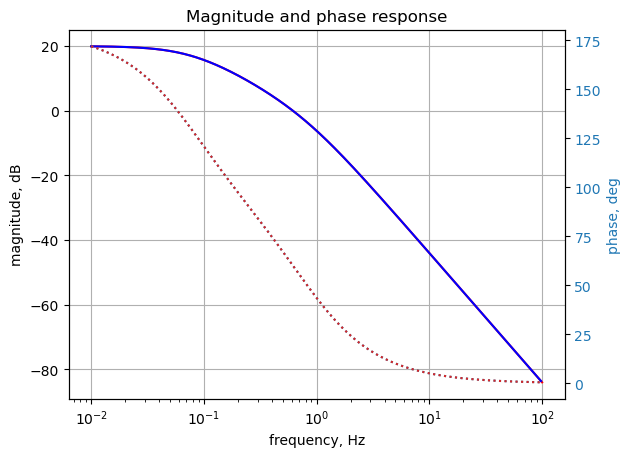

In [32]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency, 20*np.log10(np.abs(V_3)),'-r')    # Bode magnitude plot
plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency, np.unwrap(2*np.angle(V_3)/2) *180/np.pi,':',color=color)  # Bode phase plot
plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()

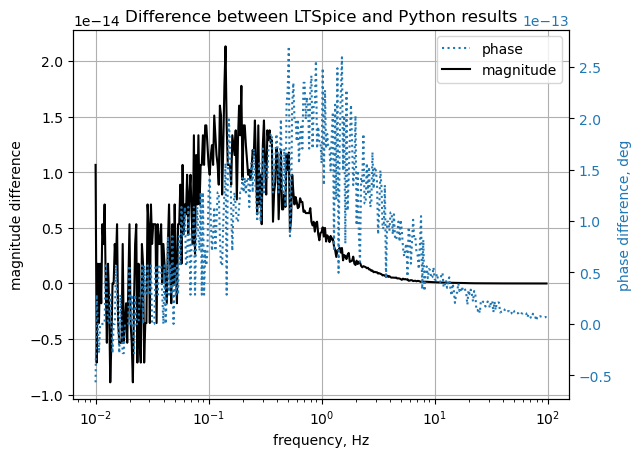

In [33]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude difference')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(frequency[0:-1], np.abs(V_3[0:-1])-10**(mag/20),'-k')    # Bode magnitude plot
#plt.semilogx(w/(2*np.pi), mag_v3,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(frequency[0:-1], np.angle(V_3[0:-1])*180/np.pi-phase,':',color=color,label='phase')  # Bode phase plot
#plt.semilogx(w/(2*np.pi), phase_v3,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase difference, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

ax2.plot(np.NaN, np.NaN, color='k', label='magnitude')

plt.legend()
plt.title('Difference between LTSpice and Python results')
plt.show()

The SymPy and LTSpice results have small error. 